In [ ]:
import os
import pandas as pd
from mla2.ensemble.random_forest import RandomForestClassifier
from mla2.ensemble.random_forest import RandomForestClassifier1
import numpy as np
#312:multiclass 316:multiclass

In [5]:
import os

origem = r'C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance'
destino = r'C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance_small'

os.makedirs(destino, exist_ok=True)

for file in os.listdir(origem):

    ori = os.path.join(origem, file)
    df = pd.read_csv(ori)

    if df.shape[0] < 700:
        dest = os.path.join(destino, file)
        os.rename(ori, dest)


In [8]:
#Removing multiclass files
os.remove(r'C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance\dataset_312_scene.csv')
os.remove(r'C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance\dataset_316_yeast_ml8.csv')

**Análise do desempenho do Random Forest incial, sem qualquer alteraçoes**

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mla.ensemble.random_forest import RandomForestClassifier  # Usando a tua implementação

# Pasta dos datasets tratados
pastas = [r"C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance",r"C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance_small"]

resultados = []
count = 1

In [39]:
# Funções de métricas sem sklearn
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision(y_true, y_pred):
    classes = np.unique(y_true)
    precisions = []
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        precisions.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    return np.mean(precisions)

def recall(y_true, y_pred):
    classes = np.unique(y_true)
    recalls = []
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        recalls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    return np.mean(recalls)

def recall_minority(y_true, y_pred):
    classes, counts = np.unique(y_true, return_counts=True)
    min_class = classes[np.argmin(counts)]
    tp = np.sum((y_pred == min_class) & (y_true == min_class))
    fn = np.sum((y_pred != min_class) & (y_true == min_class))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def balanced_accuracy(y_true, y_pred):
    classes = np.unique(y_true)
    recalls = []
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        recalls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    return np.mean(recalls)

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

def precision_recall_auc(y_true, y_score):
    if len(np.unique(y_true)) != 2:
        return np.nan
    y_true = y_true.astype(int)
    prob = y_score[:, 1]
    desc_order = np.argsort(-prob)
    y_true_sorted = y_true[desc_order]
    precision_vals = np.cumsum(y_true_sorted) / (np.arange(1, len(y_true_sorted) + 1))
    recall_vals = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    return np.trapz(precision_vals, recall_vals)


# Função para dividir treino e teste
def split_train_test(X, y, test_size=0.3, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    test_size = int(test_size * X.shape[0])
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

max_depths = [5,10,25,50]
n_estimators = [10, 50, 100, 200]

Datasets pequenos

In [ ]:
pasta = pastas[1]  # Usando a pasta com datasets pequenos

for arquivo in os.listdir(pasta):
    if arquivo.endswith(".csv"):
        caminho_arquivo = os.path.join(pasta, arquivo)
        print(f"\nTreino no dataset: {arquivo}")
        print(count, "de 48")
        count += 1

        # Carrega dados
        df = pd.read_csv(caminho_arquivo)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        num_atributos = X.shape[1]
        # Divide treino/teste
        X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)

        for depth in max_depths:
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=5,
                max_depth=depth,
                max_features= math.floor(math.sqrt(num_atributos))
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)

            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)

            resultados.append({
                "dataset": arquivo,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc,
                "max_depth": depth
            })


Treino no dataset: dataset_1004_synthetic_control.csv
1 de 48

Treino no dataset: dataset_1013_analcatdata_challenger.csv
2 de 48

Treino no dataset: dataset_1023_soybean.csv
3 de 48

Treino no dataset: dataset_1045_kc1-top5.csv
4 de 48

Treino no dataset: dataset_1059_ar1.csv
5 de 48

Treino no dataset: dataset_1061_ar4.csv
6 de 48

Treino no dataset: dataset_1064_ar6.csv
7 de 48

Treino no dataset: dataset_1065_kc3.csv
8 de 48

Treino no dataset: dataset_450_analcatdata_lawsuit.csv
9 de 48

Treino no dataset: dataset_463_backache.csv
10 de 48

Treino no dataset: dataset_757_meta.csv
11 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_764_analcatdata_apnea3.csv
12 de 48

Treino no dataset: dataset_765_analcatdata_apnea2.csv
13 de 48

Treino no dataset: dataset_767_analcatdata_apnea1.csv
14 de 48

Treino no dataset: dataset_865_analcatdata_neavote.csv
15 de 48

Treino no dataset: dataset_867_visualizing_livestock.csv
16 de 48

Treino no dataset: dataset_875_analcatdata_chlamydia.csv
17 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_940_water-treatment.csv
18 de 48

Treino no dataset: dataset_947_arsenic-male-bladder.csv
19 de 48

Treino no dataset: dataset_949_arsenic-female-bladder.csv
20 de 48

Treino no dataset: dataset_950_arsenic-female-lung.csv
21 de 48

Treino no dataset: dataset_951_arsenic-male-lung.csv
22 de 48

Treino no dataset: dataset_954_spectrometer.csv
23 de 48

Treino no dataset: dataset_968_analcatdata_birthday.csv
24 de 48

Treino no dataset: dataset_984_analcatdata_draft.csv
25 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_987_collins.csv
26 de 48


In [25]:
pasta = pastas[0] 

for arquivo in os.listdir(pasta):
    if arquivo.endswith(".csv"):
        caminho_arquivo = os.path.join(pasta, arquivo)
        print(f"\nTreino no dataset: {arquivo}")
        print(count, "de 48")
        count += 1

        # Carrega dados
        df = pd.read_csv(caminho_arquivo)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        num_atributos = X.shape[1]
        # Divide treino/teste
        X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)


        for depth in max_depths:
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=50,
                max_depth= depth,
                max_features= math.floor(math.sqrt(num_atributos)),
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)

            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)
            

            resultados.append({
                "dataset": arquivo,
                "max_depth": depth,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc
            })

# Mostrar resultados
resultados_df = pd.DataFrame(resultados)
resultados_df.to_csv("analise_inicial_rf.csv", index=False)
print("\nResultados:")
print(resultados_df)



Treino no dataset: dataset_1000_hypothyroid.csv
27 de 48

Treino no dataset: dataset_1002_ipums_la_98-small.csv
28 de 48

Treino no dataset: dataset_1014_analcatdata_dmft.csv
29 de 48

Treino no dataset: dataset_1016_vowel.csv
30 de 48

Treino no dataset: dataset_1018_ipums_la_99-small.csv
31 de 48

Treino no dataset: dataset_1020_mfeat-karhunen.csv
32 de 48

Treino no dataset: dataset_1021_page-blocks.csv
33 de 48

Treino no dataset: dataset_1022_mfeat-pixel.csv
34 de 48

Treino no dataset: dataset_1039_hiva_agnostic.csv
35 de 48

Treino no dataset: dataset_1049_pc4.csv
36 de 48

Treino no dataset: dataset_1050_pc3.csv
37 de 48

Treino no dataset: dataset_1056_mc1.csv
38 de 48

Treino no dataset: dataset_311_oil_spill.csv
39 de 48

Treino no dataset: dataset_38_sick.csv
40 de 48

Treino no dataset: dataset_958_segment.csv
41 de 48

Treino no dataset: dataset_962_mfeat-morphological.csv
42 de 48

Treino no dataset: dataset_966_analcatdata_halloffame.csv
43 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_971_mfeat-fourier.csv
44 de 48

Treino no dataset: dataset_976_JapaneseVowels.csv
45 de 48

Treino no dataset: dataset_978_mfeat-factors.csv
46 de 48

Treino no dataset: dataset_980_optdigits.csv
47 de 48

Treino no dataset: dataset_995_mfeat-zernike.csv
48 de 48

Resultados:
                                     dataset  f1_score  recall_minority  \
0         dataset_1004_synthetic_control.csv  1.000000         1.000000   
1         dataset_1004_synthetic_control.csv  0.990227         0.967742   
2         dataset_1004_synthetic_control.csv  1.000000         1.000000   
3         dataset_1004_synthetic_control.csv  0.990227         0.967742   
4    dataset_1013_analcatdata_challenger.csv  1.000000         1.000000   
..                                       ...       ...              ...   
187                dataset_980_optdigits.csv  0.955346         0.843931   
188            dataset_995_mfeat-zernike.csv  0.973214         0.903846   
189            datas

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

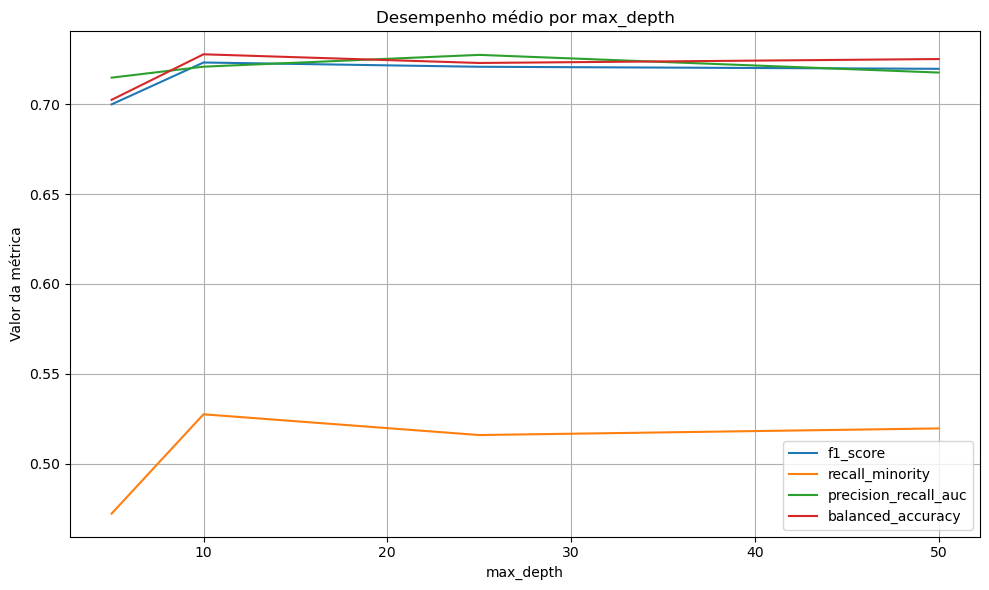

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

resultados_df=pd.read_csv(r'C:\Users\Utilizador\Desktop\RandomForest_v2\analise_inicial_depth_rf.csv')
mean_results = resultados_df.groupby("max_depth").mean(numeric_only=True).reset_index()

plt.figure(figsize=(10, 6))
for metric in ["f1_score", "recall_minority", "precision_recall_auc", "balanced_accuracy"]:
    sns.lineplot(data=mean_results, x="max_depth", y=metric, label=metric)

plt.title("Desempenho médio por max_depth")
plt.xlabel("max_depth")
plt.ylabel("Valor da métrica")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='max_depth', ylabel='recall_minority'>

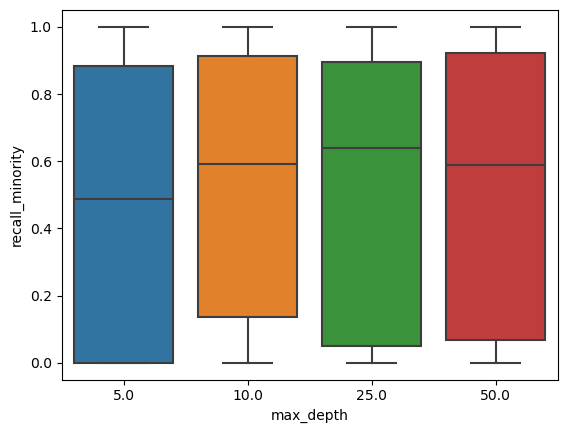

In [46]:
sns.boxplot(data=resultados_df, x="max_depth", y="recall_minority")

In [49]:
resultados_est=[]
count = 1

In [50]:
pasta = pastas[1] 

for arquivo in os.listdir(pasta):
    if arquivo.endswith(".csv"):
        caminho_arquivo = os.path.join(pasta, arquivo)
        print(f"\nTreino no dataset: {arquivo}")
        print(count, "de 48")
        count += 1

        # Carrega dados
        df = pd.read_csv(caminho_arquivo)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        num_atributos = X.shape[1]
        # Divide treino/teste
        X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)


        for n in n_estimators:
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=n,
                max_depth= 10,
                max_features= math.floor(math.sqrt(num_atributos)),
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)

            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)
            

            resultados_est.append({
                "dataset": arquivo,
                "n_estimators": n,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc
            })


Treino no dataset: dataset_1004_synthetic_control.csv
1 de 48

Treino no dataset: dataset_1013_analcatdata_challenger.csv
2 de 48

Treino no dataset: dataset_1023_soybean.csv
3 de 48

Treino no dataset: dataset_1045_kc1-top5.csv
4 de 48

Treino no dataset: dataset_1059_ar1.csv
5 de 48

Treino no dataset: dataset_1061_ar4.csv
6 de 48

Treino no dataset: dataset_1064_ar6.csv
7 de 48

Treino no dataset: dataset_1065_kc3.csv
8 de 48

Treino no dataset: dataset_450_analcatdata_lawsuit.csv
9 de 48

Treino no dataset: dataset_463_backache.csv
10 de 48

Treino no dataset: dataset_757_meta.csv
11 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_764_analcatdata_apnea3.csv
12 de 48

Treino no dataset: dataset_765_analcatdata_apnea2.csv
13 de 48

Treino no dataset: dataset_767_analcatdata_apnea1.csv
14 de 48

Treino no dataset: dataset_865_analcatdata_neavote.csv
15 de 48

Treino no dataset: dataset_867_visualizing_livestock.csv
16 de 48

Treino no dataset: dataset_875_analcatdata_chlamydia.csv
17 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_940_water-treatment.csv
18 de 48

Treino no dataset: dataset_947_arsenic-male-bladder.csv
19 de 48

Treino no dataset: dataset_949_arsenic-female-bladder.csv
20 de 48

Treino no dataset: dataset_950_arsenic-female-lung.csv
21 de 48

Treino no dataset: dataset_951_arsenic-male-lung.csv
22 de 48

Treino no dataset: dataset_954_spectrometer.csv
23 de 48

Treino no dataset: dataset_968_analcatdata_birthday.csv
24 de 48

Treino no dataset: dataset_984_analcatdata_draft.csv
25 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_987_collins.csv
26 de 48


In [51]:
pasta = pastas[0] 

for arquivo in os.listdir(pasta):
    if arquivo.endswith(".csv"):
        caminho_arquivo = os.path.join(pasta, arquivo)
        print(f"\nTreino no dataset: {arquivo}")
        print(count, "de 48")
        count += 1

        # Carrega dados
        df = pd.read_csv(caminho_arquivo)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        num_atributos = X.shape[1]
        # Divide treino/teste
        X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)


        for n in n_estimators:
            
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=n,
                max_depth= 10,
                max_features= math.floor(math.sqrt(num_atributos)),
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)

            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)
            

            resultados_est.append({
                "dataset": arquivo,
                "n_estimators": n,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc
            })

# Mostrar resultados
resultados_est_df = pd.DataFrame(resultados_est)
resultados_est_df.to_csv("analise_inicial_est_rf.csv", index=False)
print("\nResultados:")
print(resultados_est_df)


Treino no dataset: dataset_1000_hypothyroid.csv
27 de 48

Treino no dataset: dataset_1002_ipums_la_98-small.csv
28 de 48

Treino no dataset: dataset_1014_analcatdata_dmft.csv
29 de 48

Treino no dataset: dataset_1016_vowel.csv
30 de 48

Treino no dataset: dataset_1018_ipums_la_99-small.csv
31 de 48

Treino no dataset: dataset_1020_mfeat-karhunen.csv
32 de 48

Treino no dataset: dataset_1021_page-blocks.csv
33 de 48

Treino no dataset: dataset_1022_mfeat-pixel.csv
34 de 48

Treino no dataset: dataset_1039_hiva_agnostic.csv
35 de 48

Treino no dataset: dataset_1049_pc4.csv
36 de 48

Treino no dataset: dataset_1050_pc3.csv
37 de 48

Treino no dataset: dataset_1056_mc1.csv
38 de 48

Treino no dataset: dataset_311_oil_spill.csv
39 de 48

Treino no dataset: dataset_38_sick.csv
40 de 48

Treino no dataset: dataset_958_segment.csv
41 de 48

Treino no dataset: dataset_962_mfeat-morphological.csv
42 de 48

Treino no dataset: dataset_966_analcatdata_halloffame.csv
43 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_971_mfeat-fourier.csv
44 de 48

Treino no dataset: dataset_976_JapaneseVowels.csv
45 de 48

Treino no dataset: dataset_978_mfeat-factors.csv
46 de 48

Treino no dataset: dataset_980_optdigits.csv
47 de 48

Treino no dataset: dataset_995_mfeat-zernike.csv
48 de 48

Resultados:
                                     dataset  n_estimators  f1_score  \
0         dataset_1004_synthetic_control.csv            10  1.000000   
1         dataset_1004_synthetic_control.csv            50  1.000000   
2         dataset_1004_synthetic_control.csv           100  1.000000   
3         dataset_1004_synthetic_control.csv           200  1.000000   
4    dataset_1013_analcatdata_challenger.csv            10  1.000000   
..                                       ...           ...       ...   
187                dataset_980_optdigits.csv           200  0.953644   
188            dataset_995_mfeat-zernike.csv            10  0.962196   
189            dataset_995_mfeat-zernike.csv   

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

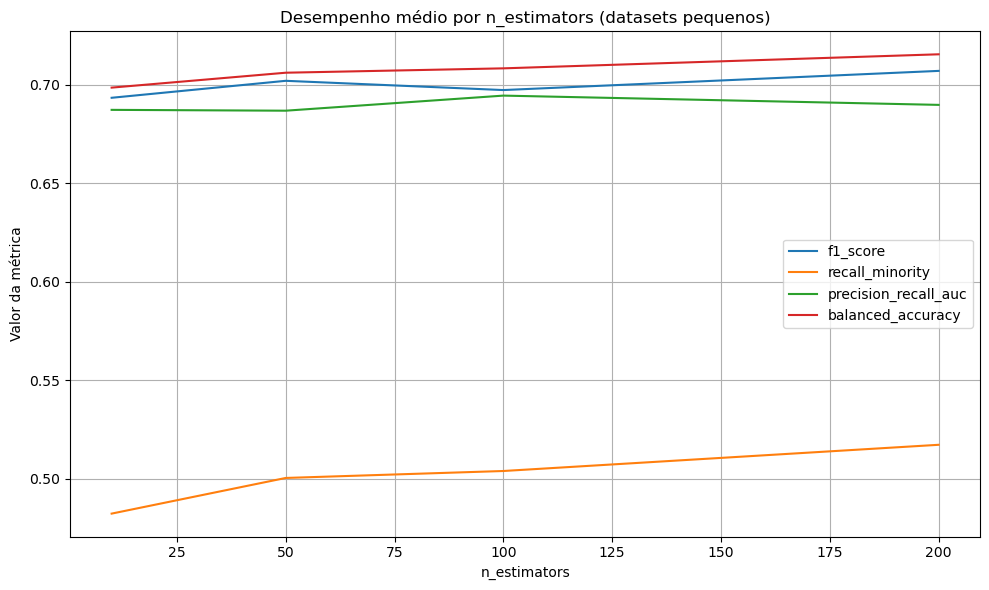

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

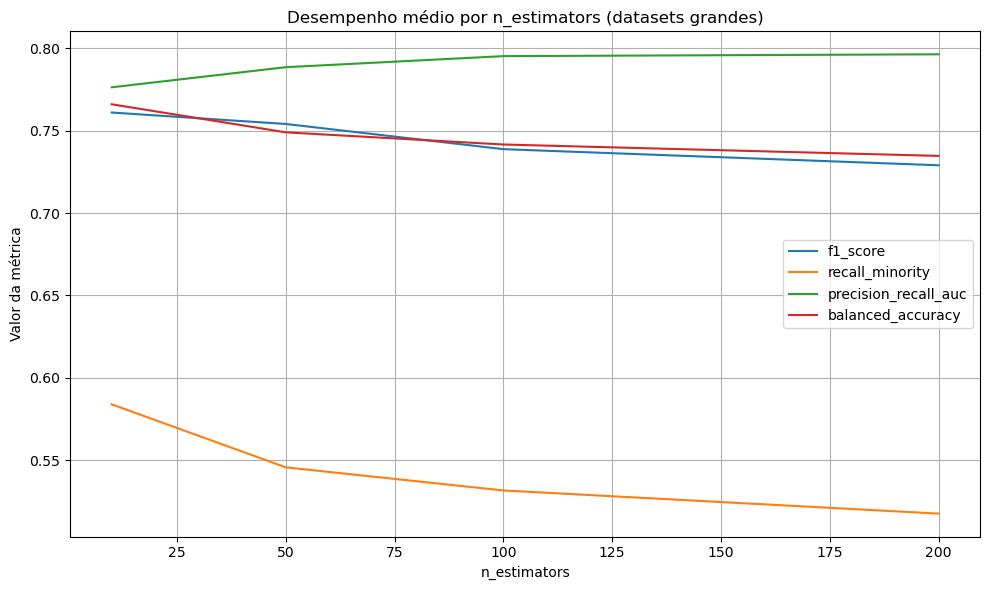

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.read_csv(r'C:\Users\Utilizador\Desktop\RandomForest_v2\analise_inicial_est_rf.csv')

small_results = results_df.iloc[:105]
large_results = results_df.iloc[105:]

# Métricas 
metrics = ["f1_score", "recall_minority", "precision_recall_auc", "balanced_accuracy"]


def plot_grouped_by_estimators(df, title):
    mean_results = df.groupby("n_estimators")[metrics].mean().reset_index()
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        sns.lineplot(data=mean_results, x="n_estimators", y=metric, label=metric)
    plt.title(title)
    plt.xlabel("n_estimators")
    plt.ylabel("Valor da métrica")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# datasets pequenos
plot_grouped_by_estimators(small_results, "Desempenho médio por n_estimators (datasets pequenos)")

# datasets grandes
plot_grouped_by_estimators(large_results, "Desempenho médio por n_estimators (datasets grandes)")


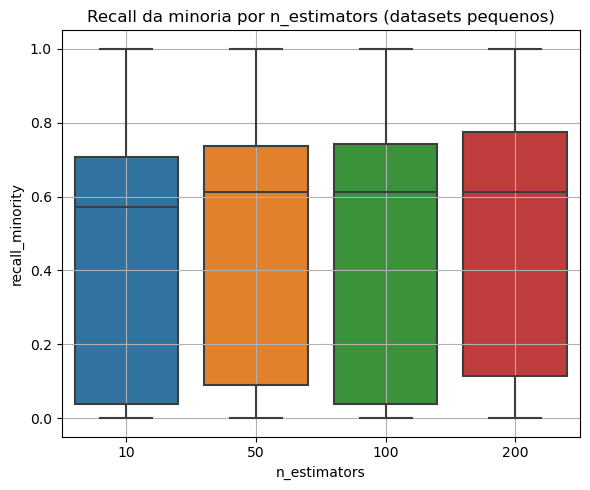

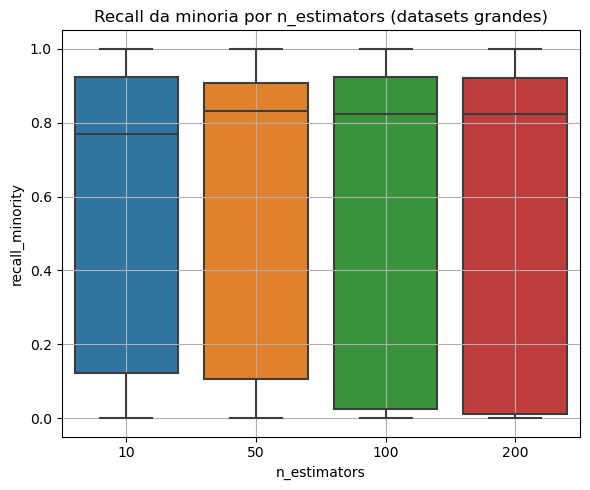

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot para datasets pequenos
plt.figure(figsize=(6, 5))
sns.boxplot(data=small_results, x="n_estimators", y="recall_minority")
plt.title("Recall da minoria por n_estimators (datasets pequenos)")
plt.xlabel("n_estimators")
plt.ylabel("recall_minority")
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot para datasets grandes
plt.figure(figsize=(6, 5))
sns.boxplot(data=large_results, x="n_estimators", y="recall_minority")
plt.title("Recall da minoria por n_estimators (datasets grandes)")
plt.xlabel("n_estimators")
plt.ylabel("recall_minority")
plt.grid(True)
plt.tight_layout()
plt.show()


**Correr com a mudança**

In [57]:
resultados_mudanca=[]
count = 1

In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mla2.ensemble.random_forest import RandomForestClassifier  # Usando a tua implementação

for pasta in pastas:
    for arquivo in os.listdir(pasta):
        if arquivo.endswith(".csv"):
            
            caminho_arquivo = os.path.join(pasta, arquivo)
            print(f"\nTreino no dataset: {arquivo}")
            print(count, "de 48")
            count += 1

            # Carrega dados
            df = pd.read_csv(caminho_arquivo)
            X = df.iloc[:, :-1].values
            y = df.iloc[:, -1].values
            num_atributos = X.shape[1]
            # Divide treino/teste
            X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)
            
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=100,
                max_depth= 10,
                max_features= math.floor(math.sqrt(num_atributos)),
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)
            
            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)
                

            resultados_mudanca.append({
                "dataset": arquivo,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc
                })
            
resultados_mudanca_df = pd.DataFrame(resultados_mudanca)
resultados_mudanca_df.to_csv("analise_mudanca.csv", index=False)
print("\nResultados:")
print(resultados_mudanca_df)


Treino no dataset: dataset_1000_hypothyroid.csv
1 de 48

Treino no dataset: dataset_1002_ipums_la_98-small.csv
2 de 48

Treino no dataset: dataset_1014_analcatdata_dmft.csv
3 de 48

Treino no dataset: dataset_1016_vowel.csv
4 de 48

Treino no dataset: dataset_1018_ipums_la_99-small.csv
5 de 48

Treino no dataset: dataset_1020_mfeat-karhunen.csv
6 de 48

Treino no dataset: dataset_1021_page-blocks.csv
7 de 48

Treino no dataset: dataset_1022_mfeat-pixel.csv
8 de 48

Treino no dataset: dataset_1039_hiva_agnostic.csv
9 de 48

Treino no dataset: dataset_1049_pc4.csv
10 de 48

Treino no dataset: dataset_1050_pc3.csv
11 de 48

Treino no dataset: dataset_1056_mc1.csv
12 de 48

Treino no dataset: dataset_311_oil_spill.csv
13 de 48

Treino no dataset: dataset_38_sick.csv
14 de 48

Treino no dataset: dataset_958_segment.csv
15 de 48

Treino no dataset: dataset_962_mfeat-morphological.csv
16 de 48

Treino no dataset: dataset_966_analcatdata_halloffame.csv
17 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_971_mfeat-fourier.csv
18 de 48

Treino no dataset: dataset_976_JapaneseVowels.csv
19 de 48

Treino no dataset: dataset_978_mfeat-factors.csv
20 de 48

Treino no dataset: dataset_980_optdigits.csv
21 de 48

Treino no dataset: dataset_995_mfeat-zernike.csv
22 de 48

Treino no dataset: dataset_1004_synthetic_control.csv
23 de 48

Treino no dataset: dataset_1013_analcatdata_challenger.csv
24 de 48

Treino no dataset: dataset_1023_soybean.csv
25 de 48

Treino no dataset: dataset_1045_kc1-top5.csv
26 de 48

Treino no dataset: dataset_1059_ar1.csv
27 de 48

Treino no dataset: dataset_1061_ar4.csv
28 de 48

Treino no dataset: dataset_1064_ar6.csv
29 de 48

Treino no dataset: dataset_1065_kc3.csv
30 de 48

Treino no dataset: dataset_450_analcatdata_lawsuit.csv
31 de 48

Treino no dataset: dataset_463_backache.csv
32 de 48

Treino no dataset: dataset_757_meta.csv
33 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_764_analcatdata_apnea3.csv
34 de 48

Treino no dataset: dataset_765_analcatdata_apnea2.csv
35 de 48

Treino no dataset: dataset_767_analcatdata_apnea1.csv
36 de 48

Treino no dataset: dataset_865_analcatdata_neavote.csv
37 de 48

Treino no dataset: dataset_867_visualizing_livestock.csv
38 de 48

Treino no dataset: dataset_875_analcatdata_chlamydia.csv
39 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_940_water-treatment.csv
40 de 48

Treino no dataset: dataset_947_arsenic-male-bladder.csv
41 de 48

Treino no dataset: dataset_949_arsenic-female-bladder.csv
42 de 48

Treino no dataset: dataset_950_arsenic-female-lung.csv
43 de 48

Treino no dataset: dataset_951_arsenic-male-lung.csv
44 de 48

Treino no dataset: dataset_954_spectrometer.csv
45 de 48

Treino no dataset: dataset_968_analcatdata_birthday.csv
46 de 48

Treino no dataset: dataset_984_analcatdata_draft.csv
47 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_987_collins.csv
48 de 48

Resultados:
                                    dataset  f1_score  recall_minority  \
0              dataset_1000_hypothyroid.csv  0.481431         0.000000   
1        dataset_1002_ipums_la_98-small.csv  0.471516         0.000000   
2         dataset_1014_analcatdata_dmft.csv  0.437647         0.000000   
3                    dataset_1016_vowel.csv  0.471530         0.000000   
4        dataset_1018_ipums_la_99-small.csv  0.483852         0.000000   
5           dataset_1020_mfeat-karhunen.csv  0.477352         0.000000   
6              dataset_1021_page-blocks.csv  0.800981         0.377143   
7              dataset_1022_mfeat-pixel.csv  0.477352         0.000000   
8            dataset_1039_hiva_agnostic.csv  0.489738         0.000000   
9                      dataset_1049_pc4.csv  0.463804         0.000000   
10                     dataset_1050_pc3.csv  0.472379         0.000000   
11                     dataset_1056_mc1.csv  0

**Análise da perceentagem de outliers nos datasets Grupo 1**

In [ ]:
"""
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

def detect_outliers(df, contamination=0.05):
    clf = IsolationForest(contamination=contamination, random_state=42)
    preds = clf.fit_predict(df)
    outliers = (preds == -1).sum()
    total = len(df)
    return (outliers / total) * 100

def main():
    datasets_folder = 'noise'
    contamination = 0.05
    outlier_percentages = []
    dataset_count = 0

    for filename in os.listdir(datasets_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(datasets_folder, filename)
            try:
                df = pd.read_csv(filepath)

                # Drop label columns if they exist
                label_columns = ['label', 'class', 'target', 'y']
                df_features = df.copy()
                for col in label_columns:
                    if col in df_features.columns:
                        df_features = df_features.drop(columns=[col])

                # Keep only numeric columns
                df_features = df_features.select_dtypes(include=[np.number])

                # Skip datasets with no numeric features
                if df_features.empty:
                    continue

                # Skip datasets with missing values
                if df_features.isnull().any().any():
                    continue

                outlier_percentage = detect_outliers(df_features, contamination=contamination)
                outlier_percentages.append(outlier_percentage)
                dataset_count += 1

            except Exception:
                continue  # Just ignore problematic datasets silently

    if outlier_percentages:
        avg_outliers = np.mean(outlier_percentages)
        print(f"Number of datasets analyzed: {dataset_count}")
        print(f"Average outlier percentage across datasets: {avg_outliers:.2f}%")
    else:
        print("No valid datasets processed.")

if __name__ == "__main__":
    main()
"""

Number of datasets analyzed: 29
Average outlier percentage across datasets: 4.04%
